In [1]:
import tensorflow as tf

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math
import sys
#sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
sys.path.insert(0,'lucashnegri-peakutils-51a679cd8428')
# sys.path.insert(0,'S1-S1-Phonocardiogram-Peak-Detection-Method-in-Python')
sys.path.insert(0,'utils')
from helper_code import *
from get_feature import *
from models import *
from Generator0 import *
from keras.preprocessing import sequence
# import peakutils
from scipy import special
import scipy.io as sio
from keras.preprocessing.sequence import pad_sequences
import peakutils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
from keras.models import Model
from keras.layers import Input 
from skimage.transform import resize
import matplotlib.pyplot as plt

2022-08-07 12:22:02.522587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 12:22:02.526380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 12:22:02.526789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 12:22:02.527293: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
pwd

'/home/jk21/Documents/hmd/jk_classifier'

In [4]:
# data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/jk21/Downloads/Data/data/murmur/train'
test_folder = '/home/jk21/Downloads/Data/data/murmur/test'


In [5]:
model_folder = 'lcnn2'

In [6]:
model_folder

'lcnn2'

In [7]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

In [8]:
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

In [9]:
winlen = 512
hoplen = 256
nmel = 120 
nsec = 20 
trim = 1 
use_mel=True
use_cqt = False 
use_stft = False
use_raw=False
use_interval=True
use_wav2=True
maxlen1 = 120000
min_dist = 500
max_interval_len=115


In [10]:
params_feature = {'samp_sec': nsec,
                  #### melspec, stft 피쳐 옵션들  
                  'pre_emphasis': 0,
                  'hop_length': hoplen,
                  'win_length': winlen,
                  'n_mels': nmel,
                  #### cqt 피쳐 옵션들  
                  'filter_scale': 1,
                  'n_bins': 80,
                  'fmin': 10,
                  'maxlen1': maxlen1,
                  'min_dist':min_dist,
                  'max_interval_len' : max_interval_len,
                  'trim' :1,
                  'use_mel' : use_mel,
                  'use_cqt' : use_cqt,
                  'use_stft' : use_stft,
                  'use_interval' : use_interval,
                  'use_wav2' : use_wav2
}

In [11]:
mm_weight = 3 #np.random.choice([2,3,4,5])
oo_weight = 3 #np.random.choice([2,3,4,5,6])
ord1 = True #np.random.choice([True,False])
mm_mean = False #np.random.choice([True,False])
dp = 0 #np.random.choice([0, .1, .2, .3])
fc = False #np.random.choice([True,False])
ext = True
chaug = 10 #np.random.choice([0, 10])
mixup = True #np.random.choice([True,False])
cout = .8 #np.random.choice([0, 0.8])
wunknown = 1 #np.random.choice([1, 0.7, .5, .2])
n1 = 0 #np.random.choice([0,2])
if n1 == 0 :
    ranfil = False
else :
    ranfil = [n1, [18,19,20,21,22,23]]

In [12]:
params_feature['ord1'] = ord1
params_feature['mm_mean'] = mm_mean
params_feature['dp'] = dp
params_feature['fc'] = fc
params_feature['ext'] = ext
params_feature['oo_weight'] = oo_weight
params_feature['mm_weight'] = mm_weight
params_feature['chaug'] = chaug
params_feature['cout'] = cout
params_feature['wunknown'] = wunknown
params_feature['mixup'] = mixup
params_feature['n1'] = n1

In [22]:
features_trn, mel_input_shape, cqt_input_shape,stft_input_shape,interval_input_shape,wav2_input_shape = get_features_3lb_all_ord(train_folder, patient_files_trn, **params_feature)


100%|███████████████████████████████████████| 751/751 [1:03:18<00:00,  5.06s/it]


melspec:  120 313
cqt:  1 1
stft:  1 1
interval:  115 1
wav2:  32 374


In [23]:
features_test, mel_input_shape, cqt_input_shape,stft_input_shape,interval_input_shape,wav2_input_shape= get_features_3lb_all_ord(test_folder, patient_files_test, **params_feature)

100%|█████████████████████████████████████████| 191/191 [21:04<00:00,  6.62s/it]


melspec:  120 313
cqt:  1 1
stft:  1 1
interval:  115 1
wav2:  32 374


In [24]:
with open('/home/jk21/Downloads/Data/features_trn_wav2.pickle', 'wb') as f:
    pickle.dump(features_trn, f, pickle.HIGHEST_PROTOCOL)

In [25]:
with open('/home/jk21/Downloads/Data/features_test_wav2.pickle', 'wb') as f:
    pickle.dump(features_test, f, pickle.HIGHEST_PROTOCOL)

In [13]:
with open('/home/jk21/Downloads/Data/features_trn_wav2.pickle', 'rb') as f:
    features_trn = pickle.load(f)

In [14]:
with open('/home/jk21/Downloads/Data/features_test_wav2.pickle', 'rb') as f:
    features_test = pickle.load(f)

In [15]:
tmp_wav2 = np.zeros((2532,224,224,1))
for i in range(len(features_trn['wav2'])):
    test_ary=features_trn['wav2'][i]
    res = resize(test_ary, (224,224,1))
    tmp_wav2[i]=res
features_trn['wav2'] = tmp_wav2

In [16]:
features_trn['wav2'] = tmp_wav2

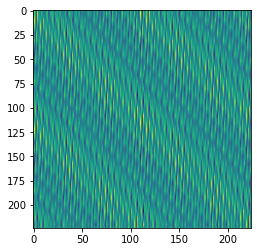

In [17]:
plt.imshow(features_trn['wav2'][100])

In [18]:
tmp_wav2 = np.zeros((631,224,224,1))
for i in range(len(features_test['wav2'])):
    test_ary=features_test['wav2'][i]
    res = resize(test_ary, (224,224,1))
    tmp_wav2[i]=res

In [19]:
features_test['wav2'] = tmp_wav2

In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=3
    )

In [20]:
def get_LCNN_o_4_dr_1(mel_input_shape, cqt_input_shape, stft_input_shape,interval_input_shape,wav2_input_shape,use_mel = True, use_cqt = True, use_stft = True, ord1 = True, dp = .5, fc = False, ext = False):
        # Create a towy model.
    
    from keras.models import Model
    from keras.layers import Input 
    
    ResNet50V2 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=3
    )
    
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    interval = keras.Input(shape=interval_input_shape, name = 'interval')
    wav2 = keras.Input(shape=wav2_input_shape, name = 'wav2')
    mel1 = keras.Input(shape=mel_input_shape, name = 'mel')
    cqt1 = keras.Input(shape=cqt_input_shape, name = 'cqt')
    stft1 = keras.Input(shape=stft_input_shape, name = 'stft')
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)
    
    ## interval embedding

    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1)(interval)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=2)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=4)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=8)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=16)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=32)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=64)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=128)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=256)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=512)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1024)(interval1)

#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=2)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=4)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=8)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=16)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=32)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=64)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=128)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=256)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=512)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1024)(interval1)    

    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=2)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=4)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=8)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=16)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=32)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=64)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=128)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=256)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=512)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1024)(interval1)
    
    interval1 = tf.keras.layers.GlobalMaxPooling1D()(interval1)
    
    #### Wav2Vec2 Embedding
    
    wav2_1 = Conv2D(3,(3,3),padding='same')(wav2)
    wav2_2 = ResNet50V2(wav2_1)

    
    
    
    ## mel embedding
    if use_mel :
        
        conv1_1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(mel1)
        conv1_2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(mel1)
        mfm2 = tensorflow.keras.layers.maximum([conv1_1, conv1_2])
        max3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm2)

        conv4_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        conv4_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        mfm5 = tensorflow.keras.layers.maximum([conv4_1, conv4_2])
        batch6 = BatchNormalization(axis=3, scale=False)(mfm5)

        conv7_1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        conv7_2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        mfm8 = tensorflow.keras.layers.maximum([conv7_1, conv7_2])

        max9 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm8)
        batch10 = BatchNormalization(axis=3, scale=False)(max9)

        conv11_1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        conv11_2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        mfm12 = tensorflow.keras.layers.maximum([conv11_1, conv11_2])
        batch13 = BatchNormalization(axis=3, scale=False)(mfm12)

        conv14_1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        conv14_2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        mfm15 = tensorflow.keras.layers.maximum([conv14_1, conv14_2])

        max16 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm15)

        conv17_1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        conv17_2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        mfm18 = tensorflow.keras.layers.maximum([conv17_1, conv17_2])
        batch19 = BatchNormalization(axis=3, scale=False)(mfm18)

        conv20_1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        conv20_2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        mfm21 = tensorflow.keras.layers.maximum([conv20_1, conv20_2])
        batch22 = BatchNormalization(axis=3, scale=False)(mfm21)

        conv23_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        conv23_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        mfm24 = tensorflow.keras.layers.maximum([conv23_1, conv23_2])
        batch25 = BatchNormalization(axis=3, scale=False)(mfm24)

        conv26_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        conv26_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        mfm27 = tensorflow.keras.layers.maximum([conv26_1, conv26_2])

        max28 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(mfm27)
        mel2 = layers.GlobalAveragePooling2D()(max28)
        mel2 = Dropout(dp)(mel2)

    if use_cqt:
        ## cqt embedding
        conv1_1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(cqt1)
        conv1_2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(cqt1)
        mfm2 = tensorflow.keras.layers.maximum([conv1_1, conv1_2])
        max3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm2)
        
        conv4_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        conv4_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        mfm5 = tensorflow.keras.layers.maximum([conv4_1, conv4_2])
        batch6 = BatchNormalization(axis=3, scale=False)(mfm5)

        conv7_1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        conv7_2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        mfm8 = tensorflow.keras.layers.maximum([conv7_1, conv7_2])

        max9 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm8)
        batch10 = BatchNormalization(axis=3, scale=False)(max9)

        conv11_1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        conv11_2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        mfm12 = tensorflow.keras.layers.maximum([conv11_1, conv11_2])
        batch13 = BatchNormalization(axis=3, scale=False)(mfm12)

        conv14_1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        conv14_2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        mfm15 = tensorflow.keras.layers.maximum([conv14_1, conv14_2])

        max16 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm15)

        conv17_1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        conv17_2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        mfm18 = tensorflow.keras.layers.maximum([conv17_1, conv17_2])
        batch19 = BatchNormalization(axis=3, scale=False)(mfm18)

        conv20_1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        conv20_2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        mfm21 = tensorflow.keras.layers.maximum([conv20_1, conv20_2])
        batch22 = BatchNormalization(axis=3, scale=False)(mfm21)

        conv23_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        conv23_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        mfm24 = tensorflow.keras.layers.maximum([conv23_1, conv23_2])
        batch25 = BatchNormalization(axis=3, scale=False)(mfm24)

        conv26_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        conv26_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        mfm27 = tensorflow.keras.layers.maximum([conv26_1, conv26_2])
        
        max28 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(mfm27)
        cqt2 = layers.GlobalAveragePooling2D()(max28)
        cqt2 = Dropout(dp)(cqt2)

    if use_stft :
        ## stft embedding
        conv1_1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(stft1)
        conv1_2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(stft1)
        mfm2 = tensorflow.keras.layers.maximum([conv1_1, conv1_2])
        max3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm2)
        
        conv4_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        conv4_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        mfm5 = tensorflow.keras.layers.maximum([conv4_1, conv4_2])
        batch6 = BatchNormalization(axis=3, scale=False)(mfm5)
        
        conv7_1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        conv7_2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        mfm8 = tensorflow.keras.layers.maximum([conv7_1, conv7_2])
        
        max9 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm8)
        batch10 = BatchNormalization(axis=3, scale=False)(max9)
        
        conv11_1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        conv11_2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        mfm12 = tensorflow.keras.layers.maximum([conv11_1, conv11_2])
        batch13 = BatchNormalization(axis=3, scale=False)(mfm12)

        conv14_1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        conv14_2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        mfm15 = tensorflow.keras.layers.maximum([conv14_1, conv14_2])
        
        max16 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm15)

        conv17_1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        conv17_2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        mfm18 = tensorflow.keras.layers.maximum([conv17_1, conv17_2])
        batch19 = BatchNormalization(axis=3, scale=False)(mfm18)

        conv20_1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        conv20_2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        mfm21 = tensorflow.keras.layers.maximum([conv20_1, conv20_2])
        batch22 = BatchNormalization(axis=3, scale=False)(mfm21)

        conv23_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        conv23_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        mfm24 = tensorflow.keras.layers.maximum([conv23_1, conv23_2])
        batch25 = BatchNormalization(axis=3, scale=False)(mfm24)

        conv26_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        conv26_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        mfm27 = tensorflow.keras.layers.maximum([conv26_1, conv26_2])
        
        max28 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(mfm27)
        stft2 = layers.GlobalAveragePooling2D()(max28)
        stft2 = Dropout(dp)(stft2)
    
    
    if use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2, stft2])
    if not use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([cqt2, stft2])
    if use_mel and not use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, stft2])
    if use_mel and use_cqt and not use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2])
    if not use_mel and not use_cqt and use_stft :  ## stft 만
        concat2 = stft2
    if use_mel and not use_cqt and not use_stft :  ### mel만
        concat2 = mel2
    if not use_mel and use_cqt and not use_stft :  ### cqt만
        concat2 = cqt2

    if ext :
        
        concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, interval1,preg])
        d1 = layers.Dense(10, activation='relu')(concat1)
        concat2 = layers.Concatenate()([concat2, d1,wav2_2])
        
    if fc :
        concat2 = layers.Dense(10, activation = "relu")(concat2)
        concat2 = Dropout(dp)(concat2)
        
    if ord1 :
        res1 = layers.Dense(2, activation = "softmax")(concat2)
        
        

        
    else :
        res1 = layers.Dense(3, activation = "softmax")(concat2)

        
        
        
#     res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,interval,wav2,mel1,stft1,cqt1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy','AUC'])
    return(model)



In [21]:
def get_LCNN_o_4_dr_2(mel_input_shape, cqt_input_shape, stft_input_shape,interval_input_shape,wav2_input_shape,use_mel = True, use_cqt = True, use_stft = True, ord1 = True, dp = .5, fc = False, ext = False):
        # Create a towy model.
    
    from keras.models import Model
    from keras.layers import Input 
    
    ResNet50V2 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2
    )
    
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    interval = keras.Input(shape=interval_input_shape, name = 'interval')
    wav2 = keras.Input(shape=wav2_input_shape, name = 'wav2')
    mel1 = keras.Input(shape=mel_input_shape, name = 'mel')
    cqt1 = keras.Input(shape=cqt_input_shape, name = 'cqt')
    stft1 = keras.Input(shape=stft_input_shape, name = 'stft')
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)
    
    ## interval embedding

    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1)(interval)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=2)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=4)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=8)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=16)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=32)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=64)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=128)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=256)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=512)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1024)(interval1)

#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=2)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=4)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=8)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=16)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=32)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=64)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=128)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=256)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=512)(interval1)
#     interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1024)(interval1)    

    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=2)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=4)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=8)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=16)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=32)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=64)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=128)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=256)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=512)(interval1)
    interval1 = tf.keras.layers.Conv1D(9, 2, padding="causal",activation='relu',dilation_rate=1024)(interval1)
    
    interval1 = tf.keras.layers.GlobalMaxPooling1D()(interval1)
    
    #### Wav2Vec2 Embedding
    
    wav2_1 = Conv2D(3,(3,3),padding='same')(wav2)
    wav2_2 = ResNet50V2(wav2_1)

    
    
    
    ## mel embedding
    if use_mel :
        
        conv1_1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(mel1)
        conv1_2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(mel1)
        mfm2 = tensorflow.keras.layers.maximum([conv1_1, conv1_2])
        max3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm2)

        conv4_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        conv4_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        mfm5 = tensorflow.keras.layers.maximum([conv4_1, conv4_2])
        batch6 = BatchNormalization(axis=3, scale=False)(mfm5)

        conv7_1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        conv7_2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        mfm8 = tensorflow.keras.layers.maximum([conv7_1, conv7_2])

        max9 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm8)
        batch10 = BatchNormalization(axis=3, scale=False)(max9)

        conv11_1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        conv11_2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        mfm12 = tensorflow.keras.layers.maximum([conv11_1, conv11_2])
        batch13 = BatchNormalization(axis=3, scale=False)(mfm12)

        conv14_1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        conv14_2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        mfm15 = tensorflow.keras.layers.maximum([conv14_1, conv14_2])

        max16 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm15)

        conv17_1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        conv17_2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        mfm18 = tensorflow.keras.layers.maximum([conv17_1, conv17_2])
        batch19 = BatchNormalization(axis=3, scale=False)(mfm18)

        conv20_1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        conv20_2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        mfm21 = tensorflow.keras.layers.maximum([conv20_1, conv20_2])
        batch22 = BatchNormalization(axis=3, scale=False)(mfm21)

        conv23_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        conv23_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        mfm24 = tensorflow.keras.layers.maximum([conv23_1, conv23_2])
        batch25 = BatchNormalization(axis=3, scale=False)(mfm24)

        conv26_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        conv26_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        mfm27 = tensorflow.keras.layers.maximum([conv26_1, conv26_2])

        max28 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(mfm27)
        mel2 = layers.GlobalAveragePooling2D()(max28)
        mel2 = Dropout(dp)(mel2)

    if use_cqt:
        ## cqt embedding
        conv1_1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(cqt1)
        conv1_2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(cqt1)
        mfm2 = tensorflow.keras.layers.maximum([conv1_1, conv1_2])
        max3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm2)
        
        conv4_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        conv4_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        mfm5 = tensorflow.keras.layers.maximum([conv4_1, conv4_2])
        batch6 = BatchNormalization(axis=3, scale=False)(mfm5)

        conv7_1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        conv7_2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        mfm8 = tensorflow.keras.layers.maximum([conv7_1, conv7_2])

        max9 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm8)
        batch10 = BatchNormalization(axis=3, scale=False)(max9)

        conv11_1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        conv11_2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        mfm12 = tensorflow.keras.layers.maximum([conv11_1, conv11_2])
        batch13 = BatchNormalization(axis=3, scale=False)(mfm12)

        conv14_1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        conv14_2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        mfm15 = tensorflow.keras.layers.maximum([conv14_1, conv14_2])

        max16 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm15)

        conv17_1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        conv17_2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        mfm18 = tensorflow.keras.layers.maximum([conv17_1, conv17_2])
        batch19 = BatchNormalization(axis=3, scale=False)(mfm18)

        conv20_1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        conv20_2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        mfm21 = tensorflow.keras.layers.maximum([conv20_1, conv20_2])
        batch22 = BatchNormalization(axis=3, scale=False)(mfm21)

        conv23_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        conv23_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        mfm24 = tensorflow.keras.layers.maximum([conv23_1, conv23_2])
        batch25 = BatchNormalization(axis=3, scale=False)(mfm24)

        conv26_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        conv26_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        mfm27 = tensorflow.keras.layers.maximum([conv26_1, conv26_2])
        
        max28 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(mfm27)
        cqt2 = layers.GlobalAveragePooling2D()(max28)
        cqt2 = Dropout(dp)(cqt2)

    if use_stft :
        ## stft embedding
        conv1_1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(stft1)
        conv1_2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(stft1)
        mfm2 = tensorflow.keras.layers.maximum([conv1_1, conv1_2])
        max3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm2)
        
        conv4_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        conv4_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max3)
        mfm5 = tensorflow.keras.layers.maximum([conv4_1, conv4_2])
        batch6 = BatchNormalization(axis=3, scale=False)(mfm5)
        
        conv7_1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        conv7_2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch6)
        mfm8 = tensorflow.keras.layers.maximum([conv7_1, conv7_2])
        
        max9 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm8)
        batch10 = BatchNormalization(axis=3, scale=False)(max9)
        
        conv11_1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        conv11_2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch10)
        mfm12 = tensorflow.keras.layers.maximum([conv11_1, conv11_2])
        batch13 = BatchNormalization(axis=3, scale=False)(mfm12)

        conv14_1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        conv14_2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch13)
        mfm15 = tensorflow.keras.layers.maximum([conv14_1, conv14_2])
        
        max16 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(mfm15)

        conv17_1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        conv17_2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(max16)
        mfm18 = tensorflow.keras.layers.maximum([conv17_1, conv17_2])
        batch19 = BatchNormalization(axis=3, scale=False)(mfm18)

        conv20_1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        conv20_2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(batch19)
        mfm21 = tensorflow.keras.layers.maximum([conv20_1, conv20_2])
        batch22 = BatchNormalization(axis=3, scale=False)(mfm21)

        conv23_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        conv23_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch22)
        mfm24 = tensorflow.keras.layers.maximum([conv23_1, conv23_2])
        batch25 = BatchNormalization(axis=3, scale=False)(mfm24)

        conv26_1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        conv26_2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(batch25)
        mfm27 = tensorflow.keras.layers.maximum([conv26_1, conv26_2])
        
        max28 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(mfm27)
        stft2 = layers.GlobalAveragePooling2D()(max28)
        stft2 = Dropout(dp)(stft2)
    
    
    if use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2, stft2])
    if not use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([cqt2, stft2])
    if use_mel and not use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, stft2])
    if use_mel and use_cqt and not use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2])
    if not use_mel and not use_cqt and use_stft :  ## stft 만
        concat2 = stft2
    if use_mel and not use_cqt and not use_stft :  ### mel만
        concat2 = mel2
    if not use_mel and use_cqt and not use_stft :  ### cqt만
        concat2 = cqt2

    if ext :
        
        concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, interval1,preg])
        d1 = layers.Dense(10, activation='relu')(concat1)
        concat2 = layers.Concatenate()([concat2, d1,wav2_2])
        
    if fc :
        concat2 = layers.Dense(10, activation = "relu")(concat2)
        concat2 = Dropout(dp)(concat2)
        
    if ord1 :
        res1 = layers.Dense(2, activation = "softmax")(concat2)
        
        

        
    else :
        res1 = layers.Dense(3, activation = "softmax")(concat2)

        
        
        
#     res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,interval,wav2,mel1,stft1,cqt1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy','AUC'])
    return(model)



In [21]:
features_trn['wav2']=features_trn['wav2'][:,:,:,np.newaxis]

In [18]:
features_test['wav2']=features_test['wav2'][:,:,:,np.newaxis]

In [22]:
mel_input_shape = features_trn['mel1'].shape[1:]

In [23]:
mel_input_shape

(120, 313, 1)

In [24]:
cqt_input_shape = features_trn['cqt1'].shape[1:]

In [25]:
cqt_input_shape

(1, 1, 1)

In [26]:
stft_input_shape = features_trn['stft1'].shape[1:]

In [27]:
stft_input_shape

(1, 1, 1)

In [28]:
interval_input_shape= features_trn['interval'].shape[1:]

In [29]:
interval_input_shape

(115, 1)

In [30]:
wav2_input_shape= features_trn['wav2'].shape[1:]

In [31]:
wav2_input_shape

(224, 224, 1)

In [32]:
for i in range(len(features_trn['interval'])):
    features_trn['interval'][i]=np.array(features_trn['interval'][i])

In [33]:
for i in range(len(features_trn['mel1'])):
    features_trn['mel1'][i]=np.array(features_trn['mel1'][i])

In [43]:
model1 = get_LCNN_o_4_dr_1(mel_input_shape, cqt_input_shape, stft_input_shape,interval_input_shape,wav2_input_shape, use_mel = use_mel, use_cqt = use_cqt, use_stft = use_stft, ord1 = ord1, dp = dp, fc = fc, ext = ext)

In [44]:

model2 = get_LCNN_o_4_dr_2(mel_input_shape, cqt_input_shape, stft_input_shape,interval_input_shape,wav2_input_shape, use_mel = use_mel, use_cqt = use_cqt, use_stft = use_stft, ord1 = ord1, dp = dp, fc = fc, ext = ext)


In [45]:
model1.layers[-5].trainable=False

In [46]:
model2.layers[-5].trainable=False

In [47]:
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mel (InputLayer)               [(None, 120, 313, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 120, 313, 32  832         ['mel[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 120, 313, 32  832         ['mel[0][0]']                    
                                )                                                           

 conv1d_98 (Conv1D)             (None, 115, 9)       171         ['conv1d_97[0][0]']              
                                                                                                  
 conv2d_87 (Conv2D)             (None, 15, 40, 64)   4160        ['max_pooling2d_18[0][0]']       
                                                                                                  
 conv2d_88 (Conv2D)             (None, 15, 40, 64)   4160        ['max_pooling2d_18[0][0]']       
                                                                                                  
 conv1d_99 (Conv1D)             (None, 115, 9)       171         ['conv1d_98[0][0]']              
                                                                                                  
 maximum_41 (Maximum)           (None, 15, 40, 64)   0           ['conv2d_87[0][0]',              
                                                                  'conv2d_88[0][0]']              
          

 is_preg (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 wav2 (InputLayer)              [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 global_average_pooling2d_4 (Gl  (None, 32)          0           ['max_pooling2d_19[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 concatenate_8 (Concatenate)    (None, 17)           0           ['dense_24[0][0]',               
                                                                  'dense_25[0][0]',               
          

In [48]:
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mel (InputLayer)               [(None, 120, 313, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 120, 313, 32  832         ['mel[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_97 (Conv2D)             (None, 120, 313, 32  832         ['mel[0][0]']                    
                                )                                                           

 conv1d_120 (Conv1D)            (None, 115, 9)       171         ['conv1d_119[0][0]']             
                                                                                                  
 conv2d_106 (Conv2D)            (None, 15, 40, 64)   4160        ['max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_107 (Conv2D)            (None, 15, 40, 64)   4160        ['max_pooling2d_22[0][0]']       
                                                                                                  
 conv1d_121 (Conv1D)            (None, 115, 9)       171         ['conv1d_120[0][0]']             
                                                                                                  
 maximum_50 (Maximum)           (None, 15, 40, 64)   0           ['conv2d_106[0][0]',             
                                                                  'conv2d_107[0][0]']             
          

 is_preg (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 wav2 (InputLayer)              [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 32)          0           ['max_pooling2d_23[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 concatenate_10 (Concatenate)   (None, 17)           0           ['dense_30[0][0]',               
                                                                  'dense_31[0][0]',               
          

In [49]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64

if mixup :
    beta_param = .7
else :
    beta_param = 0
    


params = {'batch_size': batch_size,
          #          'input_shape': (100, 313, 1),
          'shuffle': True,
          'chaug': chaug,
          'beta_param': beta_param,
          'cout': cout
#              'mixup': mixup,
          #          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          #          'highpass': [.5, [78,79,80,81,82,83,84,85]]
#              'ranfilter2' : [3, [18,19,20,21,22,23]]
          #           'dropblock' : [30, 100]
          #'device' : device
}

if mixup :
    params['mixup'] = mixup
    params['ranfilter2'] = ranfil
else :
    params['cutout'] = cout

params_no_shuffle = {'batch_size': batch_size,
                     #          'input_shape': (100, 313, 1),
                     'shuffle': False,
                     'beta_param': 0.7,
                     'mixup': False
                     #'device': device
}


# TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'], features_trn['loc'],
#             features_trn['interval'],features_trn['wav2'],features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']], 
#            features_trn['mm_labels'],  ## our Y
#                         **params)()


# ValidDGen_1 = Generator0([features_test['age'],features_test['sex'], features_test['hw'], 
#                               features_test['preg'], features_test['loc'],features_test['interval'],
#                               features_test['wav2'], features_test['mel1'],features_test['cqt1'],features_test['stft1']], 
#                              features_test['mm_labels'],  ## our Y
                         
#                          **params)()





if ord1 :
    class_weight = {0: mm_weight, 1: 1.}
else :
    class_weight = {0: mm_weight, 1: wunknown, 2:1.}

    
    
    
    

if mixup :
    
    
    TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], 
                              features_trn['preg'], features_trn['loc'],features_trn['interval'],
                              features_trn['wav2'],features_trn['mel1'],features_trn['cqt1'],
                              features_trn['stft1']],features_trn['mm_labels'],**params)()
    
    model1.fit(TrainDGen_1,
               validation_data = ([features_test['age'],features_test['sex'], features_test['hw'], 
                                   features_test['preg'], features_test['loc'],features_test['interval'],
                                   features_test['wav2'], features_test['mel1'],features_test['cqt1'],
                                   features_test['stft1']],features_test['mm_labels']),
               
               callbacks=[lr],
               steps_per_epoch=np.ceil(len(features_trn['mm_labels'])/batch_size),
               class_weight=class_weight, 
               epochs = n_epoch)
    
    
 

else :
    TrainGen = DataGenerator([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'], features_trn['loc'], 
                      features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']], 
                     mm_lbs_trn,  ## our Y
                     **params)
    model1.fit(TrainGen,
               validation_data = ([features_test['age'],features_test['sex'], features_test['hw'], 
                                   features_test['preg'], features_test['loc'], features_test['mel1'], 
                                   features_test['cqt1'], features_test['stft1']], 
                                  mm_lbs_test), 
               callbacks=[lr],
               #        steps_per_epoch=np.ceil(len(mm_lbs_trn)/64),
               class_weight=class_weight, 
               epochs = n_epoch)



Epoch 1/100
40/40 [==============================] - 21s 393ms/step - loss: 1.4606 - accuracy: 0.7004 - auc: 0.7483 - val_loss: 30.6786 - val_accuracy: 0.7892 - val_auc: 0.7915 - lr: 9.9851e-04
Epoch 2/100
40/40 [==============================] - 15s 368ms/step - loss: 0.9602 - accuracy: 0.7984 - auc: 0.8588 - val_loss: 0.4965 - val_accuracy: 0.7908 - val_auc: 0.8496 - lr: 9.9831e-04
Epoch 3/100
40/40 [==============================] - 15s 364ms/step - loss: 1.1454 - accuracy: 0.8129 - auc: 0.8594 - val_loss: 433.4399 - val_accuracy: 0.7892 - val_auc: 0.7915 - lr: 9.9807e-04
Epoch 4/100
40/40 [==============================] - 15s 364ms/step - loss: 1.0041 - accuracy: 0.7918 - auc: 0.8509 - val_loss: 0.5303 - val_accuracy: 0.8162 - val_auc: 0.8528 - lr: 9.9781e-04
Epoch 5/100
40/40 [==============================] - 15s 365ms/step - loss: 0.9477 - accuracy: 0.7887 - auc: 0.8566 - val_loss: 0.7601 - val_accuracy: 0.4374 - val_auc: 0.4276 - lr: 9.9750e-04
Epoch 6/100
40/40 [=============

40/40 [==============================] - 15s 364ms/step - loss: 0.7959 - accuracy: 0.8234 - auc: 0.8953 - val_loss: 0.6087 - val_accuracy: 0.6545 - val_auc: 0.7313 - lr: 7.4146e-04
Epoch 44/100
40/40 [==============================] - 15s 364ms/step - loss: 0.7841 - accuracy: 0.8230 - auc: 0.8937 - val_loss: 0.4253 - val_accuracy: 0.8906 - val_auc: 0.9472 - lr: 7.1587e-04
Epoch 45/100
40/40 [==============================] - 15s 367ms/step - loss: 0.7795 - accuracy: 0.8258 - auc: 0.8920 - val_loss: 0.3618 - val_accuracy: 0.9002 - val_auc: 0.9246 - lr: 6.8882e-04
Epoch 46/100
40/40 [==============================] - 15s 365ms/step - loss: 0.7782 - accuracy: 0.8141 - auc: 0.9002 - val_loss: 0.5233 - val_accuracy: 0.7607 - val_auc: 0.8445 - lr: 6.6044e-04
Epoch 47/100
40/40 [==============================] - 15s 365ms/step - loss: 0.7976 - accuracy: 0.8117 - auc: 0.8960 - val_loss: 0.3607 - val_accuracy: 0.8780 - val_auc: 0.9255 - lr: 6.3088e-04
Epoch 48/100
40/40 [=======================

40/40 [==============================] - 15s 365ms/step - loss: 0.7648 - accuracy: 0.8305 - auc: 0.9045 - val_loss: 0.3947 - val_accuracy: 0.8922 - val_auc: 0.9415 - lr: 2.1772e-05
Epoch 86/100
40/40 [==============================] - 15s 365ms/step - loss: 0.7238 - accuracy: 0.8309 - auc: 0.9111 - val_loss: 0.3771 - val_accuracy: 0.8938 - val_auc: 0.9437 - lr: 2.0352e-05
Epoch 87/100
40/40 [==============================] - 15s 365ms/step - loss: 0.7601 - accuracy: 0.8160 - auc: 0.9106 - val_loss: 0.3777 - val_accuracy: 0.8954 - val_auc: 0.9437 - lr: 1.9102e-05
Epoch 88/100
40/40 [==============================] - 15s 365ms/step - loss: 0.7751 - accuracy: 0.8238 - auc: 0.9041 - val_loss: 0.3824 - val_accuracy: 0.8938 - val_auc: 0.9434 - lr: 1.8001e-05
Epoch 89/100
40/40 [==============================] - 15s 365ms/step - loss: 0.7719 - accuracy: 0.8309 - auc: 0.8994 - val_loss: 0.3787 - val_accuracy: 0.8938 - val_auc: 0.9440 - lr: 1.7033e-05
Epoch 90/100
40/40 [=======================

In [50]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))

batch_size = 64

params = {'batch_size': batch_size,
          #          'input_shape': (100, 313, 1),
          'shuffle': True,
          'chaug': 0,
          'beta_param': beta_param,
          'cout': cout,
#              'mixup': True,
          #          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#            'highpass': [.5, [78,79,80,81,82,83,84,85]],
#              'ranfilter2' : [3, [18,19,20,21,22,23]]
        #           'dropblock' : [30, 100]
          #'device' : device
}



if mixup :
    params['mixup'] = mixup
    params['ranfilter2'] = ranfil
else :
    params['cutout'] = cout


params_no_shuffle = {'batch_size': batch_size,
                     #          'input_shape': (100, 313, 1),
                     'shuffle': False,
                     'beta_param': 0.7,
                     'mixup': False
                     #'device': device
}




if mixup :

    
    class_weight = {0: oo_weight, 1: 1.}
    TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'],
                              features_trn['loc'],features_trn['interval'],features_trn['wav2'],
                              features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']],
                             features_trn['out_labels'], **params)()

    model2.fit(TrainDGen_1,
               validation_data = ([features_test['age'],features_test['sex'], features_test['hw'],
                                   features_test['preg'], features_test['loc'],features_test['interval'],
                                   features_test['wav2'], features_test['mel1'],features_test['cqt1'],
                                   features_test['stft1']],features_test['out_labels']), 
               
               callbacks=[lr],
               steps_per_epoch=np.ceil(len(features_trn['out_labels'])/batch_size),
               class_weight=class_weight, 
               epochs = n_epoch)
    
else :
    TrainGen = DataGenerator([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'], features_trn['loc'], 
                      features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']], 
                     out_lbs_trn,  ## our Y
                     **params)
    model2.fit(TrainGen,
               validation_data = ([features_test['age'],features_test['sex'], features_test['hw'],
                                   features_test['preg'], features_test['loc'],features_test['interval'],
                                   features_test['wav2'], features_test['mel1'],features_test['cqt1'],
                                   features_test['stft1']],features_test['out_labels']), 
               callbacks=[lr],
               class_weight=class_weight, 
               epochs = n_epoch)


















Epoch 1/100
40/40 [==============================] - 21s 384ms/step - loss: 2.4493 - accuracy: 0.4883 - auc: 0.5075 - val_loss: 1716.3695 - val_accuracy: 0.5008 - val_auc: 0.5008 - lr: 9.9851e-04
Epoch 2/100
40/40 [==============================] - 14s 353ms/step - loss: 1.3387 - accuracy: 0.4770 - auc: 0.4887 - val_loss: 73.5773 - val_accuracy: 0.5008 - val_auc: 0.5008 - lr: 9.9831e-04
Epoch 3/100
40/40 [==============================] - 14s 354ms/step - loss: 1.2720 - accuracy: 0.4785 - auc: 0.4901 - val_loss: 17.2866 - val_accuracy: 0.5008 - val_auc: 0.5008 - lr: 9.9807e-04
Epoch 4/100
40/40 [==============================] - 14s 355ms/step - loss: 1.2399 - accuracy: 0.4832 - auc: 0.5066 - val_loss: 3.2924 - val_accuracy: 0.5008 - val_auc: 0.5008 - lr: 9.9781e-04
Epoch 5/100
40/40 [==============================] - 14s 356ms/step - loss: 1.2314 - accuracy: 0.4719 - auc: 0.5067 - val_loss: 0.6761 - val_accuracy: 0.4992 - val_auc: 0.6099 - lr: 9.9750e-04
Epoch 6/100
40/40 [===========

40/40 [==============================] - 14s 363ms/step - loss: 1.1976 - accuracy: 0.4848 - auc: 0.5576 - val_loss: 0.8805 - val_accuracy: 0.4992 - val_auc: 0.5949 - lr: 7.4146e-04
Epoch 44/100
40/40 [==============================] - 15s 364ms/step - loss: 1.1796 - accuracy: 0.5004 - auc: 0.5742 - val_loss: 0.6693 - val_accuracy: 0.5563 - val_auc: 0.6255 - lr: 7.1587e-04
Epoch 45/100
40/40 [==============================] - 15s 363ms/step - loss: 1.1989 - accuracy: 0.5102 - auc: 0.5663 - val_loss: 0.6898 - val_accuracy: 0.5230 - val_auc: 0.5994 - lr: 6.8882e-04
Epoch 46/100
40/40 [==============================] - 15s 363ms/step - loss: 1.1846 - accuracy: 0.5020 - auc: 0.5691 - val_loss: 0.6216 - val_accuracy: 0.6513 - val_auc: 0.7241 - lr: 6.6044e-04
Epoch 47/100
40/40 [==============================] - 15s 363ms/step - loss: 1.1913 - accuracy: 0.4949 - auc: 0.5640 - val_loss: 0.7248 - val_accuracy: 0.5135 - val_auc: 0.5986 - lr: 6.3088e-04
Epoch 48/100
40/40 [=======================

40/40 [==============================] - 15s 363ms/step - loss: 1.1058 - accuracy: 0.5938 - auc: 0.6927 - val_loss: 0.7282 - val_accuracy: 0.5658 - val_auc: 0.6038 - lr: 2.1772e-05
Epoch 86/100
40/40 [==============================] - 15s 364ms/step - loss: 1.1039 - accuracy: 0.5930 - auc: 0.6907 - val_loss: 0.7178 - val_accuracy: 0.5721 - val_auc: 0.6117 - lr: 2.0352e-05
Epoch 87/100
40/40 [==============================] - 15s 364ms/step - loss: 1.1043 - accuracy: 0.6031 - auc: 0.7054 - val_loss: 0.7188 - val_accuracy: 0.5769 - val_auc: 0.6208 - lr: 1.9102e-05
Epoch 88/100
40/40 [==============================] - 15s 364ms/step - loss: 1.1096 - accuracy: 0.5914 - auc: 0.6857 - val_loss: 0.7110 - val_accuracy: 0.5642 - val_auc: 0.6168 - lr: 1.8001e-05
Epoch 89/100
40/40 [==============================] - 15s 364ms/step - loss: 1.1008 - accuracy: 0.6082 - auc: 0.7025 - val_loss: 0.6897 - val_accuracy: 0.5990 - val_auc: 0.6353 - lr: 1.7033e-05
Epoch 90/100
40/40 [=======================

In [51]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 120,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'maxlen1': 120000,
 'min_dist': 500,
 'max_interval_len': 115,
 'trim': 1,
 'use_mel': True,
 'use_cqt': False,
 'use_stft': False,
 'use_interval': True,
 'use_wav2': True,
 'ord1': True,
 'mm_mean': False,
 'dp': 0,
 'fc': False,
 'ext': True,
 'oo_weight': 3,
 'mm_weight': 3,
 'chaug': 10,
 'cout': 0.8,
 'wunknown': 1,
 'mixup': True,
 'n1': 0}

In [52]:
params_feature['mel_shape'] = mel_input_shape
params_feature['cqt_shape'] = cqt_input_shape
params_feature['stft_shape'] = stft_input_shape
params_feature['interval_input_shape'] = interval_input_shape
params_feature['wav2_input_shape'] = wav2_input_shape

In [53]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 120,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'maxlen1': 120000,
 'min_dist': 500,
 'max_interval_len': 115,
 'trim': 1,
 'use_mel': True,
 'use_cqt': False,
 'use_stft': False,
 'use_interval': True,
 'use_wav2': True,
 'ord1': True,
 'mm_mean': False,
 'dp': 0,
 'fc': False,
 'ext': True,
 'oo_weight': 3,
 'mm_weight': 3,
 'chaug': 10,
 'cout': 0.8,
 'wunknown': 1,
 'mixup': True,
 'n1': 0,
 'mel_shape': (120, 313, 1),
 'cqt_shape': (1, 1, 1),
 'stft_shape': (1, 1, 1),
 'interval_input_shape': (115, 1),
 'wav2_input_shape': (224, 224, 1)}

In [54]:
import pickle as pk
def save_challenge_model(model_folder, model1, model2, m_name1, m_name2, param_feature) :
    os.makedirs(model_folder, exist_ok=True)
    info_fnm = os.path.join(model_folder, 'desc.pk')
    filename1 = os.path.join(model_folder, m_name1 + '_model1.hdf5')
    filename2 = os.path.join(model_folder, m_name2 + '_model2.hdf5')
    model1.save(filename1)
    model2.save(filename2)
    param_feature['model1'] = m_name1
    param_feature['model2'] = m_name2
    param_feature['model_fnm1'] = filename1
    param_feature['model_fnm2'] = filename2
    with open(info_fnm, 'wb') as f:
        pk.dump(param_feature, f, pk.HIGHEST_PROTOCOL)
    return 1

    with open(info_fnm, 'wb') as f:
        pk.dump(param_feature, f, pk.HIGHEST_PROTOCOL)
    return 1
    

In [55]:
model_folder

'lcnn2'

In [56]:
save_challenge_model(model_folder, model1, model2, m_name1 = 'lcnn1', m_name2 = 'lcnn2', param_feature = params_feature)

1

In [57]:
def load_challenge_model(model_folder, verbose):
    info_fnm = os.path.join(model_folder, 'desc.pk')
    with open(info_fnm, 'rb') as f:
        info_m = pk.load(f)

    return info_m

In [72]:
def run_challenge_model(model, data, recordings, verbose):
    
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']

##########################################################################    
    if model['model1'] == 'lcnn1' :
        model1 = get_LCNN_o_4_dr_1(model['mel_shape'],model['cqt_shape'],model['stft_shape'], model['interval_input_shape'],model['wav2_input_shape']
                                 , use_mel = model['use_mel'],use_cqt = model['use_cqt'], use_stft = model['use_stft'], 
                                 ord1 = model['ord1'], dp = model['dp'], fc = model['fc'], ext = model['ext'])    
    if model['model1'] == 'lcnn2' :
        model1 = get_LCNN_o_4_dr_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'], model['interval_input_shape'],model['wav2_input_shape']
                                 , use_mel = model['use_mel'],use_cqt = model['use_cqt'], use_stft = model['use_stft'], 
                                 ord1 = model['ord1'], dp = model['dp'], fc = model['fc'], ext = model['ext'])   
    model1.layers[-5].trainable=False
    model2.layers[-5].trainable=False
    model1.load_weights(model['model_fnm1'])
    model2.load_weights(model['model_fnm2'])
############################################################################ 


    max_interval_len = params_feature['max_interval_len']
    maxlen1 = params_feature['maxlen1']
    min_dist = params_feature['min_dist']
    
    
    # Load features.
    features = get_feature_one(data, verbose = 0)

    samp_sec = model['samp_sec'] 
    pre_emphasis = model['pre_emphasis']
    hop_length = model['hop_length']
    win_length = model['win_length']
    n_mels = model['n_mels']
    filter_scale = model['filter_scale']
    n_bins = model['n_bins']
    fmin = model['fmin']
    trim = model['trim']
    use_mel = model['use_mel']
    use_cqt = model['use_cqt']
    use_stft = model['use_stft']
    use_interval = model['use_interval']
    use_wav2 = model['use_wav2']
    maxlen1 = model['maxlen1']
    min_dist = model['min_dist']
    max_interval_len = model['max_interval_len']
    
#    use_raw = model['use_raw']
    

    features['interval'] = []
    tmp_interval=[]  
    
    features['wav2'] = []
    tmp_raw = []
    tmp=[]      
    
    from wav2vec2 import Wav2Vec2ForCTC, Wav2Vec2Config
    import tensorflow as tf
    
    config = Wav2Vec2Config()
    tmp_model = Wav2Vec2ForCTC(config)
    tmp_model.trainable=False
    
    for i in range(len(recordings)):
        data = recordings[i]/32768
        tmp_raw.append(data)
        
    tmp_pad =pad_sequences(tmp_raw, maxlen=maxlen1, dtype='float64', padding='post', truncating='post', value=0.0)
    tmp_pad = tmp_pad[:,np.newaxis,:]
    
    for i in range(len(tmp_pad)):
        tmp_feature = tmp_model(tmp_pad[i])
        tmp.append(tmp_feature)
    
    tmp=np.array(tmp, dtype=np.float32)
    new_tmp1=tmp.reshape(-1,32,374)
    features['wav2']=new_tmp1
    
    tmp_wav2 = np.zeros((len(recordings),224,224,1))
    for i in range(len(features['wav2'])):
        test_ary=features['wav2'][i]
        res = resize(test_ary, (224,224,1))
        tmp_wav2[i]=res
    features['wav2'] = tmp_wav2
    
    features['wav2'] = np.array(features['wav2'])
    
    
    for i in tqdm.tqdm(range(len(recordings))) :
        datos=recordings[i]
        filtros=sio.loadmat('./Filters1')
        try:
            X=datos
            X=X[trim*3:-trim*3]
            Fs=4000
            
            Fpa20=filtros['Fpa20'];			        # High pass filter
            Fpa20=Fpa20[0];					# High pass filter
            Fpb100=filtros['Fpb100'];		        # Low-pass Filter
            Fpb100=Fpb100[0];				# Low-pass Filter
            
            Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
            Xf=vec_nor(Xf);			
            
                    # Derivate of the Signal
            dX=derivate(Xf);				# Derivate of the signal
            dX=vec_nor(dX);					# Vector Normalizing
                    # Square of the signal
            dy=np.square(Xf);
            dy=vec_nor(dy);
                    
            size=np.shape(Xf)				# Rank or dimension of the array
            fil=size[0];					# Number of rows

            positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
            positive=positive[0];                           # Getting the Vector

            points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
            points=points[0];                               # Getting the point vector

            peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
            peaks=peaks[0];                                 # Getting the point vector

            
            for i in range(0,fil):
                if dX[i]>0:
                    positive[i]=1;
                else:
                    positive[i]=0;

            for i in range(0,fil):
                if (positive[i]==1 and positive[i+1]==0):
                    points[i]=Xf[i];
                else:
                    points[i]=0;

            indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
            lenght=np.shape(indexes)			# Get the length of the index vector		
            lenght=lenght[0];				# Get the value of the index vector

            for i in range(0,lenght):
                p=indexes[i];
                peaks[p]=points[p];
        
            n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
            
            tmp_peaks = np.diff(indexes)
                    
            tmp_interval.append(tmp_peaks)
                    
           
        except:
            print(i)
            tmp_peaks = np.zeros(maxlen)
            tmp_interval.append(tmp_peaks)
                    
     
    padded =pad_sequences(tmp_interval, maxlen=max_interval_len, dtype='float64', padding='post', truncating='post', value=0.0)
        
    for i in range(len(padded)):
        features['interval'].append(padded[i])
        
        
    for i in range(len(features['interval'])):
        features['interval'][i] = np.array(features['interval'][i])
        
    features['interval'] = np.array(features['interval'])
    
    
    
    features['mel1'] = []
    for i in range(len(recordings)) :
        if use_mel :
            mel1 = feature_extract_melspec(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                           win_length = win_length, n_mels = n_mels)[0]
        else :
            mel1 = np.zeros( (1,1) )
            
        features['mel1'].append(mel1)
        
    M, N = features['mel1'][0].shape
    
    if use_mel :
        for i in range(len(features['mel1'])) :
            features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
    
    features['mel1'] = np.array(features['mel1'])

    
  
    features['cqt1'] = []
    for i in range(len(recordings)) :
        if use_cqt :
            mel1 = feature_extract_cqt(recordings[i], samp_sec=samp_sec, pre_emphasis = pre_emphasis, filter_scale = filter_scale, 
                                        n_bins = n_bins, fmin = fmin)[0]
        else:
            mel1 = np.zeros( (1,1,1) )
            
        features['cqt1'].append(mel1)
        
    M, N,__ = features['cqt1'][0].shape
    
    if use_cqt :
        for i in range(len(features['cqt1'])) :
            features['cqt1'][i] = features['cqt1'][i].reshape(M,N,1)   
    
    features['cqt1'] = np.array(features['cqt1'])
    
    
    features['stft1'] = []
    for i in range(len(recordings)) :
        if use_stft :
            mel1 = feature_extract_stft(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                        win_length = win_length)[0]
        else :
            mel1 = np.zeros( (1,1,1) )
        
        features['stft1'].append(mel1)
        
    M, N,__ = features['stft1'][0].shape
    if use_stft :
        for i in range(len(features['stft1'])) :
            features['stft1'][i] = features['stft1'][i].reshape(M,N,1)           
    features['stft1'] = np.array(features['stft1'])
    
#     return features       

    #    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], 
                           features['loc'], features['interval'],features['wav2'],features['mel1'], features['stft1'], features['cqt1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], 
                           features['loc'], features['interval'],features['wav2'],features['mel1'], features['stft1'], features['cqt1']])
    if model['ord1'] :
        idx1 = res1.argmax(axis=0)[0]
        murmur_p = res1[idx1,]  ## mumur 확률 최대화 되는 애 뽑기
        murmur_probabilities = np.zeros((3,))
        murmur_probabilities[0] = murmur_p[0]
        murmur_probabilities[1] = 0
        murmur_probabilities[2] = murmur_p[1]
        outcome_probabilities = res2.mean(axis = 0) ##  outcome 은 그냥 평균으로 뽑기
    else :
        if model['mm_mean'] :
            murmur_probabilities = res1.mean(axis = 0)
        else :
            idx1 = res1.argmax(axis=0)[0]
            murmur_probabilities = res1[idx1,]  ## mumur 확률 최대화 되는 애 뽑기
        outcome_probabilities = res2.mean(axis = 0) ##  outcome 은 그냥 평균으로 뽑기

        
    murmur_labels = np.zeros(len(murmur_classes), dtype=np.int_)
    
    
    if murmur_probabilities[0] > 0.482 :
        idx = 0
    else :
        idx = 2
    murmur_labels[idx] = 1

    outcome_labels = np.zeros(len(outcome_classes), dtype=np.int_)
    if outcome_probabilities[0] > 0.607 :
        idx = 0
    else :
        idx = 1    
        # idx = np.argmax(outcome_probabilities)
    outcome_labels[idx] = 1
    
    # Concatenate classes, labels, and probabilities.
    classes = murmur_classes + outcome_classes
    labels = np.concatenate((murmur_labels, outcome_labels))
    probabilities = np.concatenate((murmur_probabilities, outcome_probabilities))
    
    return classes, labels, probabilities

In [73]:
model_folder

'lcnn2'

In [74]:
data_folder = test_folder

In [75]:
data_folder

'/home/jk21/Downloads/Data/data/murmur/test'

In [76]:
output_folder ='/home/jk21/Documents/hmd/jk_classifier/out_lcnn2'

In [77]:
allow_failures=True

In [78]:
verbose=1

In [79]:
model = load_challenge_model(model_folder, verbose)

In [80]:
patient_files = find_patient_files(data_folder)

In [81]:
num_patient_files = len(patient_files)

In [82]:
patient_data = load_patient_data(patient_files[0])

In [83]:
patient_data

'33151 4 4000\nAV 33151_AV.hea 33151_AV.wav 33151_AV.tsv\nPV 33151_PV.hea 33151_PV.wav 33151_PV.tsv\nTV 33151_TV.hea 33151_TV.wav 33151_TV.tsv\nMV 33151_MV.hea 33151_MV.wav 33151_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 141.0\n#Weight: 30.9\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: MV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Plateau\n#Systolic murmur grading: I/VI\n#Systolic murmur pitch: Low\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [84]:
recordings = load_recordings(data_folder, patient_data)

In [85]:
classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


In [86]:
classes

['Present', 'Unknown', 'Absent', 'Abnormal', 'Normal']

In [87]:
# Run model.
def run_model(model_folder, data_folder, output_folder, allow_failures, verbose=1):
    # Load models.
    if verbose >= 1:
        print('Loading Challenge model...')

    model = load_challenge_model(model_folder, verbose) ### Teams: Implement this function!!!

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Create a folder for the Challenge outputs if it does not already exist.
    os.makedirs(output_folder, exist_ok=True)

    # Run the team's model on the Challenge data.
    if verbose >= 1:
        print('Running model on Challenge data...')

    # Iterate over the patient files.
    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        patient_data = load_patient_data(patient_files[i])
        recordings = load_recordings(data_folder, patient_data)

        # Allow or disallow the model to fail on parts of the data; helpful for debugging.
        try:
            classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!
        except:
            if allow_failures:
                if verbose >= 2:
                    print('... failed.')
                classes, labels, probabilities = list(), list(), list()
            else:
                raise

        # Save Challenge outputs.
        head, tail = os.path.split(patient_files[i])
        root, extension = os.path.splitext(tail)
        output_file = os.path.join(output_folder, root + '.csv')
        patient_id = get_patient_id(patient_data)
        save_challenge_outputs(output_file, patient_id, classes, labels, probabilities)

    if verbose >= 1:
        print('Done.')

In [88]:
test_folder

'/home/jk21/Downloads/Data/data/murmur/test'

In [89]:
output_folder = '/home/jk21/Documents/hmd/jk_classifier/out_lcnn2'

In [90]:
run_model(model_folder, test_folder, output_folder, allow_failures = True, verbose = 2)

Loading Challenge model...
Running model on Challenge data...
    1/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


    2/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


    3/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.13it/s]


    4/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.64it/s]


    5/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


    6/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


    7/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02it/s]


    8/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


    9/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


    10/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.52it/s]


    11/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14it/s]


    12/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.92it/s]


    13/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.24it/s]


    14/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.91it/s]


    15/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.85it/s]


    16/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.32it/s]


    17/191...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


    18/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


    19/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11it/s]


    20/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


    21/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.75it/s]


    22/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


    23/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


    24/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


    25/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58it/s]


    26/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.85it/s]


    27/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.73it/s]


    28/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


    29/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


    30/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44it/s]


    31/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


    32/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.12it/s]


    33/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


    34/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


    35/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


    36/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.17it/s]


    37/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.68it/s]


    38/191...


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


    39/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.33it/s]


    40/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.98it/s]


    41/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.81it/s]


    42/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


    43/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.57it/s]


    44/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.75it/s]


    45/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]


    46/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22it/s]


    47/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.99it/s]


    48/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


    49/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.88it/s]


    50/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.43it/s]


    51/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.85it/s]


    52/191...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


    53/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.88it/s]


    54/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


    55/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.48it/s]


    56/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22it/s]


    57/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.75it/s]


    58/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


    59/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


    60/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s]


    61/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.04it/s]


    62/191...


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


    63/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


    64/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.73it/s]


    65/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


    66/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


    67/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


    68/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41it/s]


    69/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.96it/s]


    70/191...


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


    71/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


    72/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43it/s]


    73/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.78it/s]


    74/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.53it/s]


    75/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


    76/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22it/s]


    77/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03it/s]


    78/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]


    79/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


    80/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.43it/s]


    81/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.57it/s]


    82/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.60it/s]


    83/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]


    84/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


    85/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


    86/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.25it/s]


    87/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


    88/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53it/s]


    89/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22it/s]


    90/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]


    91/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


    92/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.79it/s]


    93/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.60it/s]


    94/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.84it/s]


    95/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


    96/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


    97/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.62it/s]


    98/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


    99/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95it/s]


    100/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.24it/s]


    101/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.05it/s]


    102/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


    103/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


    104/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.61it/s]


    105/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.59it/s]


    106/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


    107/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


    108/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


    109/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


    110/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


    111/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


    112/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


    113/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


    114/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]


    115/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


    116/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.28it/s]


    117/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


    118/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.61it/s]


    119/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08it/s]


    120/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28it/s]


    121/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.04it/s]


    122/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.71it/s]


    123/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]


    124/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21it/s]


    125/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


    126/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.65it/s]


    127/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.55it/s]


    128/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]


    129/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.66it/s]


    130/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


    131/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


    132/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.32it/s]


    133/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


    134/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.72it/s]


    135/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


    136/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.29it/s]


    137/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


    138/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.39it/s]


    139/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


    140/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49it/s]


    141/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


    142/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.24it/s]


    143/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40it/s]


    144/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28it/s]


    145/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


    146/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46it/s]


    147/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.83it/s]


    148/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


    149/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


    150/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.89it/s]


    151/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.91it/s]


    152/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.02it/s]


    153/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.21it/s]


    154/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


    155/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


    156/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


    157/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]


    158/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


    159/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


    160/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.52it/s]


    161/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28it/s]


    162/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22it/s]


    163/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]


    164/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


    165/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]


    166/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.04it/s]


    167/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]


    168/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


    169/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.36it/s]


    170/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]


    171/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]


    172/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]


    173/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.37it/s]


    174/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.42it/s]


    175/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]


    176/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


    177/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.70it/s]


    178/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95it/s]


    179/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.02it/s]


    180/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.67it/s]


    181/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.02it/s]


    182/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


    183/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


    184/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


    185/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85it/s]


    186/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


    187/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.21it/s]


    188/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


    189/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.94it/s]


    190/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


    191/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Done.


In [91]:
from evaluate_model import *



In [92]:
murmur_scores, outcome_scores = evaluate_model(test_folder, output_folder)
classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
    + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string

if len(sys.argv) == 3:
    print(output_string)
elif len(sys.argv) == 4:
    with open(sys.argv[3], 'w') as f:
        f.write(output_string)

#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.756,0.590,0.515,0.785,0.760,16326.918

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.687,0.664,0.631,0.634,0.674,12278.547

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.938,0.500,0.830
AUPRC,0.800,0.073,0.896
F-measure,0.680,0.000,0.863
Accuracy,0.868,0.000,0.842

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.687,0.687
AUPRC,0.678,0.650
F-measure,0.660,0.602
Accuracy,0.694,0.570



In [93]:
label_folder = test_folder
murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Abnormal', 'Normal']

# Load and parse label and model output files.
label_files, output_files = find_challenge_files(label_folder, output_folder)
murmur_labels = load_murmurs(label_files, murmur_classes)
murmur_binary_outputs, murmur_scalar_outputs = load_classifier_outputs(output_files, murmur_classes)
outcome_labels = load_outcomes(label_files, outcome_classes)
outcome_binary_outputs, outcome_scalar_outputs = load_classifier_outputs(output_files, outcome_classes)


print(np.mean(murmur_scalar_outputs[:,0]))
print(np.mean(murmur_scalar_outputs[:,2]))
print(np.mean(outcome_scalar_outputs[:,0]))
print(np.mean(outcome_scalar_outputs[:,1]))

0.43261930576637775
0.5673806944676719
0.621152148118818
0.37884785305143026


In [94]:
for th1 in [0.01, 0.05, 0.1, 0.15,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8] :
    murmur_binary_outputs[:,0] = murmur_scalar_outputs[:,0] > th1
    murmur_binary_outputs[:,2] = murmur_scalar_outputs[:,2] > 1 - th1
    outcome_binary_outputs[:,0] = outcome_scalar_outputs[:,0] > th1
    outcome_binary_outputs[:,1] = outcome_scalar_outputs[:,1] > 1 - th1
    # For each patient, set the 'Present' or 'Abnormal' class to positive if no class is positive or if multiple classes are positive.
    murmur_labels = enforce_positives(murmur_labels, murmur_classes, 'Present')
    murmur_binary_outputs = enforce_positives(murmur_binary_outputs, murmur_classes, 'Present')
    outcome_labels = enforce_positives(outcome_labels, outcome_classes, 'Abnormal')
    outcome_binary_outputs = enforce_positives(outcome_binary_outputs, outcome_classes, 'Abnormal')
    # Evaluate the murmur model by comparing the labels and model outputs.
    murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes = compute_auc(murmur_labels, murmur_scalar_outputs)
    murmur_f_measure, murmur_f_measure_classes = compute_f_measure(murmur_labels, murmur_binary_outputs)
    murmur_accuracy, murmur_accuracy_classes = compute_accuracy(murmur_labels, murmur_binary_outputs)
    murmur_weighted_accuracy = compute_weighted_accuracy(murmur_labels, murmur_binary_outputs, murmur_classes) # This is the murmur scoring metric.
    murmur_cost = compute_cost(outcome_labels, murmur_binary_outputs, outcome_classes, murmur_classes) # Use *outcomes* to score *murmurs* for the Challenge cost metric, but this is not the actual murmur scoring metric.
    murmur_scores = (murmur_classes, murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes, \
                 murmur_f_measure, murmur_f_measure_classes, murmur_accuracy, murmur_accuracy_classes, murmur_weighted_accuracy, murmur_cost)

    # Evaluate the outcome model by comparing the labels and model outputs.
    outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes = compute_auc(outcome_labels, outcome_scalar_outputs)
    outcome_f_measure, outcome_f_measure_classes = compute_f_measure(outcome_labels, outcome_binary_outputs)
    outcome_accuracy, outcome_accuracy_classes = compute_accuracy(outcome_labels, outcome_binary_outputs)
    outcome_weighted_accuracy = compute_weighted_accuracy(outcome_labels, outcome_binary_outputs, outcome_classes)
    outcome_cost = compute_cost(outcome_labels, outcome_binary_outputs, outcome_classes, outcome_classes) # This is the clinical outcomes scoring metric.
    outcome_scores = (outcome_classes, outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes, \
                  outcome_f_measure, outcome_f_measure_classes, outcome_accuracy, outcome_accuracy_classes, outcome_weighted_accuracy, outcome_cost)



    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
    murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
    outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
                + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string
    print("threshold: ", th1)
    print(output_string)
    print("-------------")

threshold:  0.01
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.756,0.590,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.687,0.664,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.938,0.500,0.830
AUPRC,0.800,0.073,0.896
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.687,0.687
AUPRC,0.678,0.650
F-measure,0.678,0.000
Accuracy,1.000,0.000

-------------
threshold:  0.05
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.756,0.590,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.687,0.664,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.938,0.500,0.830
AUPRC,0.800,0.073,0.896
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AU